# EECE-571T - Assignment 2

### Mount on Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Colab Notebooks/EECE571T_asn2/

/content/gdrive/My Drive/Colab Notebooks/EECE571T_asn2


### Imports

In [3]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

Running on torch.__version__ =  1.13.1+cu116


### Helper Functions

In [4]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

# a function to make gray-scale images the same shape as color images
def gray_to_color(x):
    return x.repeat(3, 1, 1)

# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  

## Q1

### Dataset and Dataloader

In [5]:
# Use standard MNIST dataset
class MyDataset(torchvision.datasets.MNIST):    
    def __init__(self, *args, debug=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug = debug
    
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        img = data[0]
        label = data[1]
        return {'image': img, 'label': label}
    
    def __len__(self):
        return super().__len__()

dataset = MyDataset(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
    debug=True,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

### ToDo: train, validation, test split

The standard MNIST dataset does not provide a validation set. Use 20% of the training data as the validation set.

The standard MNIST dataset has a test set, and you can download it similar to downloading the train set, only by setting the train label to 'False'. Use the test set only for final the evaluation.

In [6]:
# ToDo: load the test set
# mnist_trainset = dataset(root='./data', train=True, download=True, transform=None)
# mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
dataset_test = MyDataset(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
    debug=True,
)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, num_workers=0)

In [7]:
len(loader)

469

In [8]:
len(loader_test)

79

In [9]:
# 128*469 # 60,032
# 128*79 # 10,112
# validation_size = 128*469*0.2 
# train_size =  128*469*0.8
# print(train_size, validation_size)
# valid_batch = 469*0.2
# train_batch = 469*0.8
# print(train_batch, valid_batch)

In [10]:
# t_loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)
# v_loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)
len(dataset) # dataset.shape - doesn't work

60000

In [11]:
len(dataset_test)

10000

In [12]:
train = torchvision.datasets.MNIST('./', train = True, download=True, transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]))

In [13]:
# ToDo: split the training data into train and validation, and define the dataloaders
from torch.utils.data import random_split
train, val = random_split(dataset, [48000, 12000])
train_loader = torch.utils.data.DataLoader(train, batch_size=128, num_workers=0)
val_loader = torch.utils.data.DataLoader(val, batch_size=128, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=128, num_workers=0)

In [14]:
# ToDo: print the size of train, validation, and test sets
print('Train set: {}'.format(len(train)))
print('Validation set: {}'.format(len(val)))
print('Test set: {}'.format(len(dataset_test)))

Train set: 48000
Validation set: 12000
Test set: 10000


### Network

In [15]:
# an example of using available models in PyTorch
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = torchvision.models.resnet18(num_classes=10)
    
    def forward(self, input_dict):        
        pred_label = self.resnet18(input_dict['image'])
        return {'label': pred_label}

# a simple CNN model, implemented from the scratch
class MyNetwork(nn.Module):    
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)        
        self.fc = nn.Linear(32*26*26, 10)
        
    def forward(self, input_dict):                 
        x = self.conv1(input_dict['image'])
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        pred_label = nn.functional.log_softmax(x, dim=1)

        return {'label': pred_label}

# You can choose either of the defined networks, or define your own neural net
network = MyNetwork().to('cuda')
print(network)

MyNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=21632, out_features=10, bias=True)
)


### Training

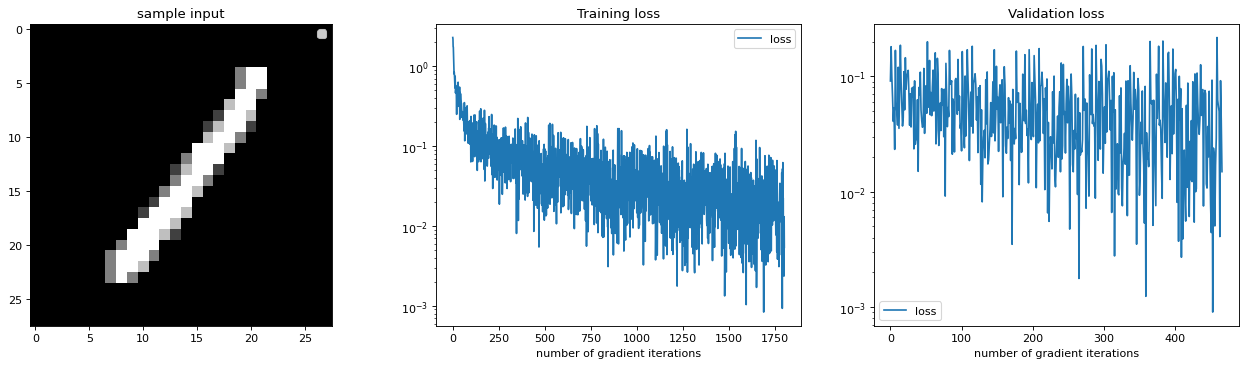

Validation epoch 4, iteration 90 of 94 (95 %), loss=0.014906753785908222


In [16]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):        
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss and backward the gradient
        loss = nn.CrossEntropyLoss()(pred['label'], batch_gpu['label'])        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())           

        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            

            # plot some sample image inputs
            plot_images(batch_cpu['image'][0:1], ax=axes[0])    
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))            

    val_iter = iter(val_loader)
    network.eval()    
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = nn.CrossEntropyLoss()(pred['label'], batch_gpu['label'])        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[2].cla()            

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))            
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [17]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')        
        pred = network(batch_gpu)['label'].argmax(dim=1, keepdim=True)                                         
        correct += pred.eq(batch_gpu['label'].view_as(pred)).sum().item()        
        total += pred.shape[0]
           
    return correct / total

In [18]:
# ToDo: report accuracy on train, validation, and test sets
train_acc = get_accuracy(network, train_loader)
val_acc = get_accuracy(network, val_loader)
test_acc = get_accuracy(network, test_loader)

print(f" training accuracy is {train_acc}\n validation accuracy {val_acc}\n test accuracy {test_acc}")

 training accuracy is 0.9940208333333334
 validation accuracy 0.9859166666666667
 test accuracy 0.988


In [19]:
# Some testing for me 
# %matplotlib inline
# to_plot = ['input', 'output']

# fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
# axes = fig.subplots(1,2)
# plot_images(next(iter(train_loader))['image'], ax=axes[0])
# plot_images(next(iter(train_loader))['image'][0:1], ax=axes[1])
#
# %matplotlib inline
# to_plot = ['input', 'output']

# fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
# axes = fig.subplots(1,2)
# plot_images(next(iter(test_loader))['image'], ax=axes[0])
# plot_images(next(iter(test_loader))['image'][0:1], ax=axes[1])


 sample output - predictions: 7, 2, 1, 0, 4


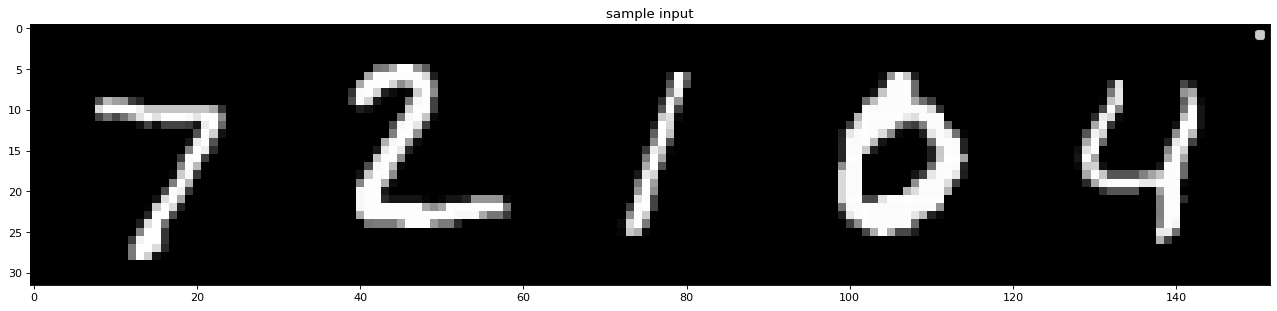

In [20]:
# ToDo: Plot the input images and output of your network for a few samples in the test set
%matplotlib inline
to_plot = ['input', 'output']

fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1)

network.eval()
test_iter = iter(test_loader)

batch_cpu = next(test_iter)
batch_gpu = dict_to_device(batch_cpu, 'cuda')
pred = network(batch_gpu)['label'].argmax(dim=1, keepdim=True)


plot_images(batch_cpu['image'][0:5], ax=axes)    
axes.legend()
axes.set_title('sample input')
# pred['label'][0:1]
print()
print(f" sample output - predictions: {pred[0:5][0][0]}, {pred[0:5][1][0]}, {pred[0:5][2][0]}, {pred[0:5][3][0]}, {pred[0:5][4][0]}")

## Q2

### Dataset and Dataloader

In [21]:
# Use standard MNIST dataset
class AnomalyDataset(torch.utils.data.Dataset):
    def __init__(self, data):          
        self.data = data
        self.digits = {0:[], 1:[], 2:[], 3:[], 4:[]}        
        for idx in range(len(self.data)):    
            digit = self.data[idx][1]
            if digit in self.digits.keys():
                self.digits[digit].append(idx)        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):      
        norm, anomaly = random.sample(self.digits.keys(), k=2)
        anomaly_loc, = random.sample([0, 1, 2], k=1)
        norm1_idx, norm2_idx = random.sample(self.digits[norm], k=2)
        anomaly_idx, = random.sample(self.digits[anomaly], k=1)
        if anomaly_loc == 0:
            img0 = self.data[anomaly_idx][0]
            img1 = self.data[norm1_idx][0]
            img2 = self.data[norm2_idx][0]
        elif anomaly_loc == 1:
            img0 = self.data[norm1_idx][0]
            img1 = self.data[anomaly_idx][0]
            img2 = self.data[norm2_idx][0]
        elif anomaly_loc == 2:
            img0 = self.data[norm1_idx][0]
            img1 = self.data[norm2_idx][0]
            img2 = self.data[anomaly_idx][0]          

        return {'img0': img0, 'img1': img1, 'img2': img2, 'index': anomaly_loc}        

dataset = AnomalyDataset(torchvision.datasets.MNIST(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
))

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

In [22]:
print('Selected digits and their frequencies:')
for key, value in loader.dataset.digits.items():
    print(key, len(value))

Selected digits and their frequencies:
0 5923
1 6742
2 5958
3 6131
4 5842


### ToDo: train, validation, test split

Use 20% of the training data as the validation set.

The standard MNIST dataset has a test set, and you can download it similar to downloading the train set, only by setting the train label to 'False'. Use the test set only for final the evaluation.

In [23]:
# ToDo: load the test set
test_set = AnomalyDataset(torchvision.datasets.MNIST(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
))

In [24]:
len(dataset)

60000

In [25]:
len(test_set)

10000

In [26]:
# ToDo: define the dataloaders
from torch.utils.data import random_split
train, val = random_split(dataset, [48000, 12000])

train_loader = torch.utils.data.DataLoader(train, batch_size=128, num_workers=0)
val_loader = torch.utils.data.DataLoader(val, batch_size=128, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, num_workers=0)

In [27]:
# ToDo: print the size of train, validation, and test sets
print('Train set: {}'.format(len(train)))
print('Validation set: {}'.format(len(val)))
print('Test set: {}'.format(len(dataset_test)))

Train set: 48000
Validation set: 12000
Test set: 10000


### ToDo: Network

Implement a neural network that takes three images as input and returns the index of the image with the different digit.

Your network should take a python dictionary as input and extract the input images from it. Your network should return a python dictionaly containing a key named 'index'.

In [28]:
# ToDo: Implement your neural network from scratch
class MyNetwork(nn.Module):    
    def __init__(self):
        super(MyNetwork, self).__init__()

        # ToDo: code here
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        
        # (W_in−F+2P)/S+1
        # multiply by 3 cause 3 images and, 3 for the second arg because size 3 array for index
        #self.fc = nn.Linear(32*82*26, 3)
        self.fc = nn.Linear(32*82*26, 128)
        self.fc2 = nn.Linear(128, 3)
        #self.fc = nn.Linear(64*81*26, 3)
        
    def forward(self, input_dict):                         
        img0 = input_dict['img0']        
        img1 = input_dict['img1']
        img2 = input_dict['img2']
        
        # ToDo: code here
        l = ['img0', 'img1', 'img2']
        preds = []
        img = torch.cat((img0, img1, img2), 2)
        #print(img.shape)
        #print(img.shape) # torch.Size([128, 3, 84, 28])
        x = self.conv1(img)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)  
        x = self.batch_norm2(x)     

        x = x.view(x.size(0), -1)
        #print(x.shape) # torch.Size([128, 68224])
        x = self.fc(x)
        x = self.relu2(x)
        x = self.fc2(x)
        #print(x.shape)
        pred_index = nn.functional.log_softmax(x, dim=1)
        
        # Hint: use padding in conv layers to adjust the dimensions
        # Hint: max-pooling and ReLU layers can be useful
        # Hint: choose a suitable activation function for the last layer 
        

        return {'index': pred_index}

network = MyNetwork().to('cuda')
print(network)

MyNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=68224, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


### ToDo: Training

In [29]:
# ToDo: define a suitable loss function 
def my_loss_function(predicted_index, target_index):

  # code here
  loss = nn.CrossEntropyLoss()(predicted_index, target_index) 
  return loss 

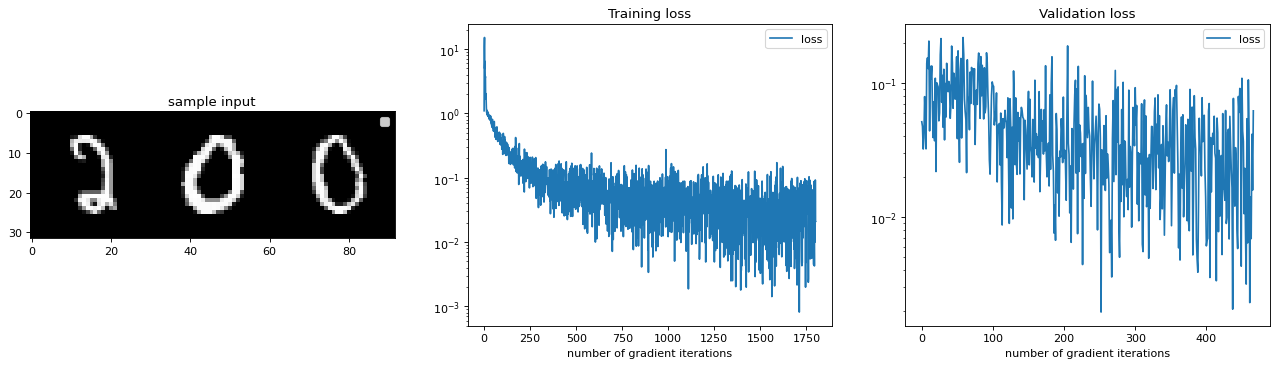

Validation epoch 4, iteration 90 of 94 (95 %), loss=0.06197446957230568


In [30]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):        
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss and backward the gradient
        loss = my_loss_function(pred['index'], batch_gpu['index'])        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())           

        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            

            # plot some sample image inputs            
            plot_images(torch.cat((batch_cpu['img0'][0:1], batch_cpu['img1'][0:1], batch_cpu['img2'][0:1]), 0), ax=axes[0])    
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))            

    val_iter = iter(val_loader)
    network.eval()    
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = my_loss_function(pred['index'], batch_gpu['index'])        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[2].cla()            

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))            
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [31]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')        
        pred = network(batch_gpu)['index'].argmax(dim=1, keepdim=True)                                         
        correct += pred.eq(batch_gpu['index'].view_as(pred)).sum().item()        
        total += pred.shape[0]
           
    return correct / total

In [32]:
# ToDo: report accuracy on train, validation, and test sets
train_acc = get_accuracy(network, train_loader)
val_acc = get_accuracy(network, val_loader)
test_acc = get_accuracy(network, test_loader)
print()
print(f" training accuracy is {train_acc}\n validation accuracy {val_acc}\n test accuracy {test_acc}")

<ipython-input-21-f1fe172a35a6>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  norm, anomaly = random.sample(self.digits.keys(), k=2)



 training accuracy is 0.9895625
 validation accuracy 0.9891666666666666
 test accuracy 0.99


<ipython-input-21-f1fe172a35a6>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  norm, anomaly = random.sample(self.digits.keys(), k=2)



 sample outputs - predictions: input0: 1 and input1: 1


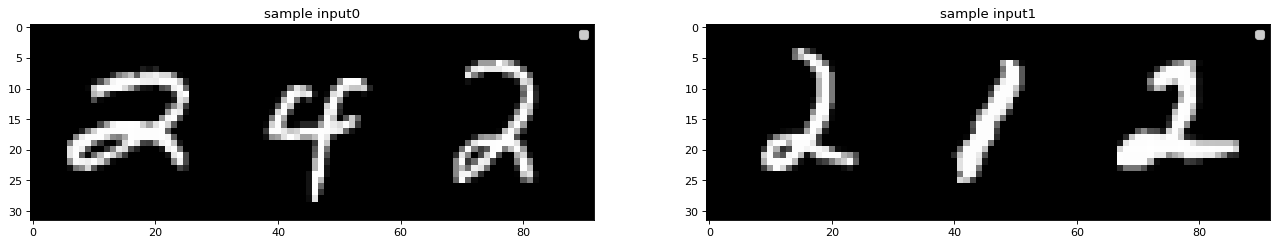

In [33]:
# ToDo: Plot the input images and output of your network for a few samples in the test set
%matplotlib inline
to_plot = ['input', 'output']

fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

test_iter = iter(test_loader)
network.eval()
batch_cpu = next(test_iter)
batch_gpu = dict_to_device(batch_cpu, 'cuda')
# pred = network(batch_gpu)['label'].argmax(dim=1, keepdim=True)
pred = network(batch_gpu)['index'].argmax(dim=1, keepdim=True)

plot_images(torch.cat((batch_cpu['img0'][0:1], batch_cpu['img1'][0:1], batch_cpu['img2'][0:1]), 0), ax=axes[0])   
axes[0].legend()
axes[0].set_title('sample input0')

plot_images(torch.cat((batch_cpu['img0'][1:2], batch_cpu['img1'][1:2], batch_cpu['img2'][1:2]), 0), ax=axes[1])   
axes[1].legend()
axes[1].set_title('sample input1')
print()
print(f" sample outputs - predictions: input0: {pred[0][0]} and input1: {pred[1][0]}")

## Q3

### Load and Tokenize Data

In [34]:
#pd.read_csv('./imdb_processed.csv')
data = pd.read_csv('imdb_processed.csv')
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [35]:
data.shape

(50000, 2)

In [36]:
data.dtypes

processed    object
label         int64
dtype: object

In [37]:
# obtain list of words
words = ' '.join(data.processed.values).split()

# check our list
words[30:40]

[',',
 'show',
 'faint',
 'hearted',
 'timid',
 '.',
 'This',
 'show',
 'pull',
 'punch']

In [38]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
token2word = dict(enumerate(vocab, 1))
token2word[0] = '<PAD>'
word2token = {word: id for id, word in token2word.items()}

In [39]:
# tokenize reviews
reviews = data.processed.values
reviews_tokenized = [[word2token[word] for word in review.split()] for review in tqdm(reviews)]

# padding sequences
def pad_features(reviews, pad_id, seq_length):    
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    for i, row in enumerate(reviews):        
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

features = pad_features(reviews_tokenized, pad_id=word2token['<PAD>'], seq_length=256)

print('number of reviews:', len(reviews_tokenized))
print('seq_length:', len(features[0]))

# print first-5 words of first 3 reviews
print('\n first-five words of the first-three reviews:')
print('===============')
features[:3, :5]

100%|██████████| 50000/50000 [00:01<00:00, 25499.03it/s]


number of reviews: 50000
seq_length: 256

 first-five words of the first-three reviews:


array([[ 191, 1083,  930,   81, 3724],
       [  47,  328,   59,  244,    1],
       [   3,   95,  328,   30, 1041]])

### Dataloader

In [40]:
# we use 70%, 15%, 15% for train, validation, and test sets
train_size = .7     
val_size = .5
labels = data.label.to_numpy()       

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [41]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, labels):                  
        self.data = torch.utils.data.TensorDataset(torch.from_numpy(reviews), torch.from_numpy(labels))#.float())        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):                                
        review = self.data[index][0]
        label = self.data[index][1]

        return {'review': review, 'label': label}        


train_set = MyDataset(train_x, train_y)
val_set = MyDataset(val_x, val_y)
test_set = MyDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=128)

### ToDo: Network

Implement a neural network based on Long short-term memory (LSTM) that takes a series of words (a review) as input and returns the label of the review indicating whether it is positive (1) or negative (0).

Your network should take a python dictionary as input and extract the input sentences from it. Your network should return a python dictionaly containing a key named 'label'.

In [42]:
# ToDo: Implement your neural network 
class SentimentLSTM(nn.Module):
    def __init__(self):
        super(SentimentLSTM, self).__init__()

        # ToDo: code here
        self.embedding = torch.nn.Embedding(121301, 256)
        self.lstm = torch.nn.LSTM(256,128, batch_first = True)    
        self.dropout = torch.nn.Dropout(p=0.5)    

        self.fc = torch.nn.Linear(128, 2) # out 2 because we want either 0 or 1
        
        self.sig = torch.nn.Sigmoid()

    def forward(self, input_dict):              
        x = input_dict['review'] 
        
        # ToDo: code here
        emb = self.embedding(x)
        out,(next, curr) = self.lstm(emb)

        next.squeeze_(0)
        t = self.dropout(next)
        pred_label = self.fc(next)
        pred_label = self.sig(pred_label)
        # print(pred_label)
        # print(pred_label.shape)
        return {'label': pred_label}

network = SentimentLSTM().to('cuda')
print(network)

SentimentLSTM(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (sig): Sigmoid()
)


### ToDo: Training

In [43]:
# ToDo: define a suitable loss function 
def my_loss_function(predicted_label, target_label):

  # code here
  loss = nn.CrossEntropyLoss()(predicted_label, target_label) #nn.BCELoss()(predicted_label, target_label)
  return loss 

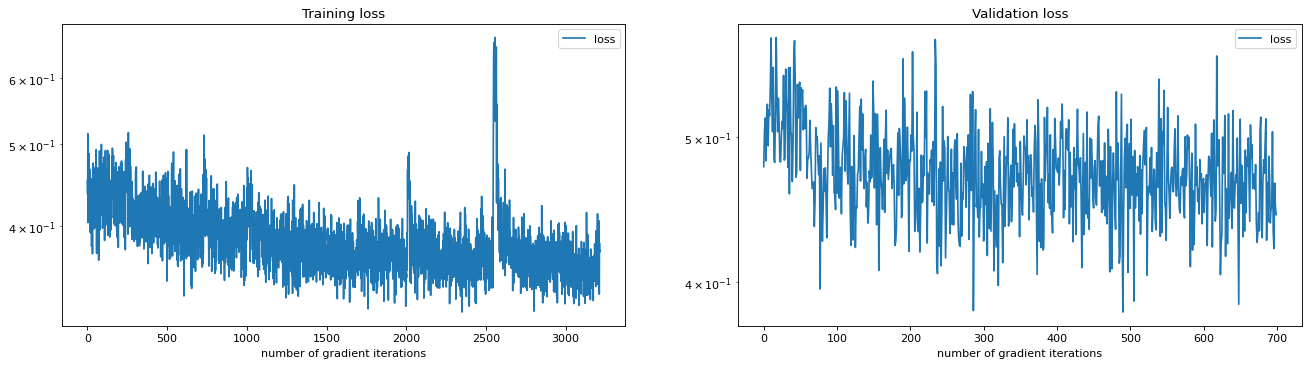

Validation epoch 11, iteration 50 of 59 (84 %), loss=0.44364503026008606


In [47]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 12
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):        
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss and backward the gradient        
        loss = my_loss_function(pred['label'], batch_gpu['label'])        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())           

        if i%100==0:            
            axes[0].cla()                        

            # plot the training error on a log plot
            axes[0].plot(train_losses, label='loss')
            axes[0].set_yscale('log')
            axes[0].set_title('Training loss')
            axes[0].set_xlabel('number of gradient iterations')
            axes[0].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))            

    val_iter = iter(val_loader)
    network.eval()    
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = my_loss_function(pred['label'], batch_gpu['label'])        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[1].cla()            

            # plot the validation error on a log plot
            axes[1].plot(val_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Validation loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))            
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you might need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [48]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')        
        pred = network(batch_gpu)['label'].argmax(dim=1, keepdim=True) 
        binary_pred = torch.where(pred < 0.5, 0, 1).squeeze(-1)
        correct += binary_pred.eq(batch_gpu['label']).sum().item()        
        total += binary_pred.shape[0]
           
    return correct / total

In [49]:
# ToDo: report accuracy on train, validation, and test sets
train_acc = get_accuracy(network, train_loader)
val_acc = get_accuracy(network, val_loader)
test_acc = get_accuracy(network, test_loader)

print(f" training accuracy is {train_acc}\n validation accuracy {val_acc}\n test accuracy {test_acc}")

 training accuracy is 0.9606
 validation accuracy 0.8448
 test accuracy 0.8497333333333333


In [50]:
# ToDo: print the input review and output of your network for one positive
# negative and positive below 
rev1_text = reviews[-1]
rev1 = test_set[-1]
rev1_label = test_set[-1]['label'].item()
network.eval()
batch_gpu = dict_to_device(rev1, 'cuda')
pred_rev1 = network(batch_gpu)['label'].argmax(dim=0, keepdim=True).item() # no bacth so dim=0
#print(pred_rev1)
print("First Review:\n")
print(rev1_text)
#print()
print(f"First Review Label: {rev1_label}, First Review Prediction: {pred_rev1}")
print()

rev2_text = reviews[-5]
rev2 = test_set[-5]
rev2_label = test_set[-5]['label'].item()
network.eval()
batch_gpu = dict_to_device(rev2, 'cuda')
pred_rev2 = network(batch_gpu)['label'].argmax(dim=0, keepdim=True).item() 
#print(pred_rev1)
print("Second Review:\n")
print(rev2_text)
#print()
print(f"Second Review Label: {rev2_label}, Second Review Prediction: {pred_rev2}")

First Review:

No one expects Star Trek movie high art , fan expect movie good best episode . Unfortunately , movie muddled , implausible plot left cringing - far worst nine far movie . Even chance watch well known character interact another movie save movie - including goofy scene Kirk , Spock McCoy Yosemite . I would say movie worth rental , hardly worth watching , however True Fan need see movie , renting movie way see - even cable channel avoid movie .
First Review Label: 0, First Review Prediction: 0

Second Review:

I thought movie right good job . It creative original first , expecting . It whole lotta fun . think like , come DVD I going pay money proudly , every last cent . Sharon Stone great , always , even movie horrible Catwoman , movie , one movie underrated lifetime , probably become classic like yr . Don wait classic , watch enjoy . Don expect masterpiece , something thats gripping soul touching , allow get life get involved . All , movie entertaining recommend people see